## Understanding uncertainty in linear models 


In this lesson we are going to explore the use of Bayesian linear modeling in data analysis. In particular we are going to use uncertainty quantification as a tool dealing with multiple factors, and better understanding the results of a model. 

We are going to start with the problem of dealing with associations. 
Linear models, or statistical models in general, are tools that can be used to get insights about the world through the analysis of data. However, the answer we get from a model must be questioned and verified, by exploring the ability and uncertainty of the model in describing the data, and by challenging it against alternative hypothesis.

In [1]:
import numpy as np
import pandas as pd
import scipy 
import matplotlib.pyplot as plt 

%run tools.py

This lesson is inspired by Chapter 4 of the book *Statistical Rethinking*. We will start analysing the dataset *WaffleDivorce* providing demographic information from the individual states of the Unisted States. It is structured as follows:

- Location : State name
- Loc : State abbreviation
- Population : 2010 population in millions
- MedianAgeMarriage: 2005-2010 median age at marriage
- Marriage : 2009 marriage rate per 1000 adults
- Marriage.SE : Standard error of rate
- Divorce : 2009 divorce rate per 1000 adults
- Divorce.SE : Standard error of rate
- WaffleHouses : Number of diners
- South : 1 indicates Southern State
- Slaves1860 : Number of slaves in 1860 census
- Population1860 : Population from 1860 census
- PropSlaves1860 : Proportion of total population that were slaves in 1860

In [2]:
data = pd.read_csv('WaffleDivorce.csv',sep=';')
print(data.columns)

Index(['Location', 'Loc', 'Population', 'MedianAgeMarriage', 'Marriage',
       'Marriage SE', 'Divorce', 'Divorce SE', 'WaffleHouses', 'South',
       'Slaves1860', 'Population1860', 'PropSlaves1860'],
      dtype='object')


Our first analysis consists in investigating the relationship between divorce rate and marriage rate:

In [3]:
data['Marriage_s'] = (data.Marriage - np.mean(data.Marriage))/np.std(data.Marriage)
data['MedianAgeMarriage_s'] = (data.MedianAgeMarriage - np.mean(data.MedianAgeMarriage))/np.std(data.MedianAgeMarriage)

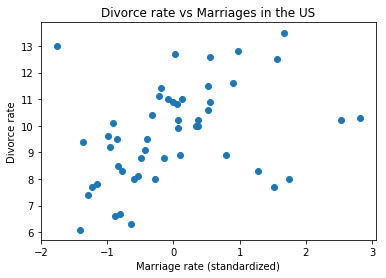

In [4]:
plt.scatter(data.Marriage_s,data.Divorce)
plt.xlabel('Marriage rate (standardized)')
plt.ylabel('Divorce rate')
plt.title('Divorce rate vs Marriages in the US')
plt.show()

The data seems to point to a pretty consistent association. What this could mean? Let's explore this association with our linear model.

In [9]:
expr = 'Divorce ~  Marriage_s'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 0
prior_a_sigma = 10
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 20
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

In [10]:
solution_regression = laplace_solution_regression(expr, data, likelihood, priors)

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 106.55497908929982
 hess_inv: array([[0.05688542, 0.00038849, 0.00071478],
       [0.00038849, 0.05604463, 0.00110135],
       [0.00071478, 0.00110135, 0.02840311]])
      jac: array([-9.53674316e-07,  0.00000000e+00, -1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 137
      nit: 19
     njev: 27
   status: 0
  success: True
        x: array([9.68258682, 0.67327966, 1.67190694])


In [11]:
posterior_stats(solution_regression, ['a','b','sigma'])

           mean        SD      7.5%      92.5%
a      9.692707  0.238474  9.345538  10.035587
b      0.667974  0.243731  0.309118   1.006926
sigma  1.662343  0.173426  1.415114   1.907151


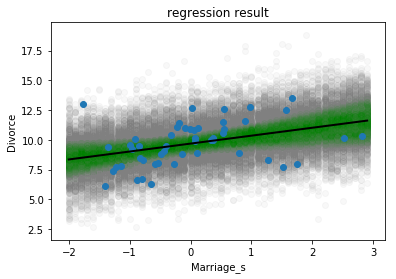

In [12]:
posterior_plot_univariate_regression(solution_regression, np.arange(-2,3,0.1), data, names = ['Marriage_s','Divorce'])

The model seems to support the existence of this association. For each point of increase in marriage rate, there seems to be roughly 0.7 increase in divorce rate.

Let's now explore the association between divorce rate and the median age of marriage.  

      fun: 99.29130616042913
 hess_inv: array([[ 3.99058173e-02,  4.06307820e-03, -1.55173191e-05],
       [ 4.06307820e-03,  3.26573558e-02,  4.37050949e-04],
       [-1.55173191e-05,  4.37050949e-04,  2.04684627e-02]])
      jac: array([0.00000000e+00, 9.53674316e-07, 1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 160
      nit: 22
     njev: 32
   status: 0
  success: True
        x: array([ 9.68395182, -1.07608201,  1.44573571])
           mean        SD      7.5%     92.5%
a      9.685529  0.209825  9.381795  9.976610
b     -1.079546  0.187235 -1.346553 -0.810505
sigma  1.451843  0.139679  1.260852  1.656636


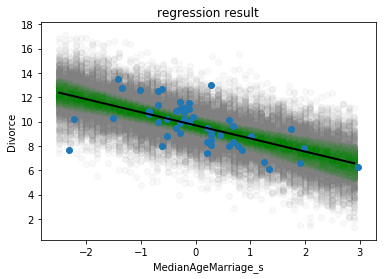

In [13]:
expr = 'Divorce ~  MedianAgeMarriage_s'
solution_regression = laplace_solution_regression(expr, data, likelihood, priors)
posterior_stats(solution_regression, ['a','b','sigma'])
posterior_plot_univariate_regression(solution_regression, np.arange(-2.5,3,0.1), data, names = ['MedianAgeMarriage_s','Divorce'])

Even now the model seems to support this relationship. Which predictor is the best? 
The question we can ask with such a model are:

- If I know the marriage rate, what additional information age at marriage brings?
- If I know age at marriage, what additional information marriage rate brings?

We can try with some preliminary study, called *residual analysis*.
The idea consists in ''removing'' the effect of a predictor from the other, and then estimate the residual predictive power. Let's see this principle in action.

In [14]:
expr = 'MedianAgeMarriage_s ~  Marriage_s'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 0
prior_a_sigma = 10
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 20
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 62.04014961774394
 hess_inv: array([[ 9.57798603e-03,  1.08967716e-04,  2.64736906e-05],
       [ 1.08967716e-04,  9.23466604e-03, -2.27275702e-05],
       [ 2.64736906e-05, -2.27275702e-05,  4.82971977e-03]])
      jac: array([ 0.00000000e+00, -1.43051147e-06, -1.43051147e-06])
  message: 'Optimization terminated successfully.'
     nfev: 152
      nit: 15
     njev: 29
   status: 0
  success: True
        x: array([-5.98507685e-09, -7.21026763e-01,  6.92835187e-01])
           mean        SD      7.5%     92.5%
a     -0.006899  0.097819 -0.145318  0.138806
b     -0.718728  0.091892 -0.854204 -0.588933
sigma  0.688612  0.069695  0.583867  0.786500


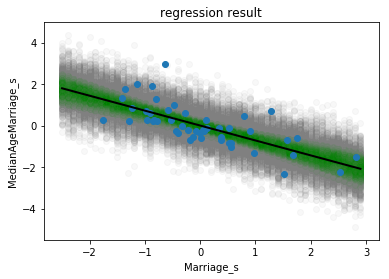

In [15]:
solution_regression = laplace_solution_regression(expr, data, likelihood, priors)
posterior_stats(solution_regression, ['a','b','sigma'])
posterior_plot_univariate_regression(solution_regression, np.arange(-2.5,3,0.1), data, names = ['Marriage_s','MedianAgeMarriage_s'])

Once having computed the residuals, we can regress them against divorce rate:

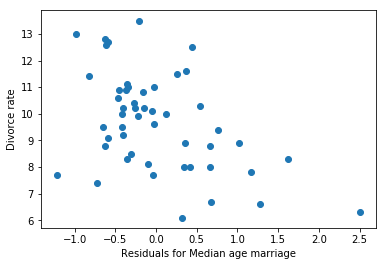

In [18]:
mean_preds = np.mean(post_sample_Laplace(solution_regression, 1000),0)
predictions_median_age_m = mean_preds[0] + data.Marriage_s * mean_preds[1]
residuals_median_age_m = data.MedianAgeMarriage_s - predictions_median_age_m

data['MedianAgeMarriage_residuals'] = residuals_median_age_m
plt.scatter(data.MedianAgeMarriage_residuals,data.Divorce)
plt.xlabel('Residuals for Median age marriage')
plt.ylabel('Divorce rate')
plt.show()



Even after removint the effect of marriage rate, there seem to be still some relationship left. Let's investigate this relationship to verify its extent.

**Exercise.** Find a 85% confidence bound for this association.

In [19]:
expr = 'Divorce ~ MedianAgeMarriage_residuals'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 0
prior_a_sigma = 10
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 20
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 104.04160805207022
 hess_inv: array([[ 5.10671080e-02,  1.31947916e-03, -4.99193526e-05],
       [ 1.31947916e-03,  9.61973207e-02, -3.92987087e-04],
       [-4.99193526e-05, -3.92987087e-04,  2.52699739e-02]])
      jac: array([ 1.90734863e-06, -1.90734863e-06,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 135
      nit: 11
     njev: 25
   status: 0
  success: True
        x: array([ 9.69003695, -1.2248609 ,  1.58975247])
           mean        SD      7.5%      92.5%
a      9.682723  0.218959  9.364823  10.001708
b     -1.222452  0.320953 -1.668395  -0.739709
sigma  1.589725  0.161705  1.365156   1.821214


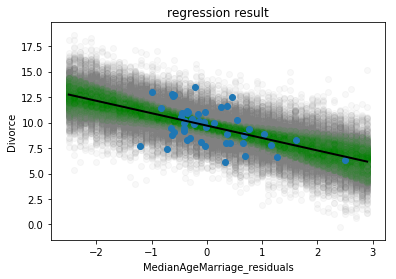

In [20]:
solution_regression = laplace_solution_regression(expr, data, likelihood, priors)
posterior_stats(solution_regression, ['a','b','sigma'])
posterior_plot_univariate_regression(solution_regression, np.arange(-2.5,3,0.1), data, names = ['MedianAgeMarriage_residuals','Divorce'])

**Exercise.** Repeat the analysis by computing the residuals with respect to median age. 

In [21]:
expr = 'Marriage_s ~ MedianAgeMarriage_s'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 0
prior_a_sigma = 10
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 20
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

      fun: 62.04014961774392
 hess_inv: array([[ 9.63412876e-03, -3.18137557e-05,  1.12392722e-05],
       [-3.18137557e-05,  9.43259309e-03,  1.53848524e-06],
       [ 1.12392722e-05,  1.53848524e-06,  4.72571384e-03]])
      jac: array([-4.76837158e-07,  0.00000000e+00,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 170
      nit: 24
     njev: 34
   status: 0
  success: True
        x: array([-9.73587840e-09, -7.21026753e-01,  6.92835193e-01])
           mean        SD      7.5%     92.5%
a     -0.003879  0.096415 -0.147262  0.129649
b     -0.721306  0.095915 -0.862737 -0.583696
sigma  0.687983  0.071418  0.585853  0.789359


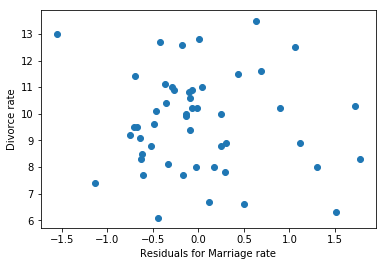

In [22]:
solution_regression = laplace_solution_regression(expr, data, likelihood, priors)
posterior_stats(solution_regression, ['a','b','sigma'])
#posterior_plot_univariate_regression(solution_regression, np.arange(-2.5,3,0.1), data, names = ['Marriage_s','MedianAgeMarriage_s'])

mean_preds = np.mean(post_sample_Laplace(solution_regression, 1000),0)
predictions_marriage = mean_preds[0] + data.MedianAgeMarriage_s * mean_preds[1]
residuals_marriage = data.Marriage_s - predictions_marriage

data['Marriage_residuals'] = residuals_marriage
plt.scatter(data.Marriage_residuals,data.Divorce)
plt.xlabel('Residuals for Marriage rate')
plt.ylabel('Divorce rate')
plt.show()


/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 110.1240952960822
 hess_inv: array([[ 0.05936062,  0.00407854,  0.00183056],
       [ 0.00407854,  0.13209452, -0.00155467],
       [ 0.00183056, -0.00155467,  0.02982153]])
      jac: array([ 1.90734863e-06, -2.86102295e-06, -3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 173
      nit: 23
     njev: 34
   status: 0
  success: True
        x: array([ 9.68187289, -0.22604356,  1.7956889 ])
           mean        SD      7.5%      92.5%
a      9.675773  0.252848  9.309280  10.038107
b     -0.228577  0.357942 -0.749918   0.300550
sigma  1.797546  0.170335  1.558464   2.044477


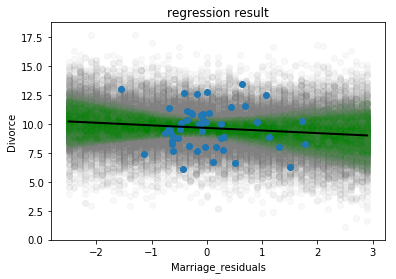

In [23]:
expr = 'Divorce ~ Marriage_residuals'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 0
prior_a_sigma = 10
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 20
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

solution_regression = laplace_solution_regression(expr, data, likelihood, priors)
posterior_stats(solution_regression, ['a','b','sigma'])
posterior_plot_univariate_regression(solution_regression, np.arange(-2.5,3,0.1), data, names = ['Marriage_residuals','Divorce'])

What is the conclusion of this analysis?

This is the right moment to fit a model with both variables.

In [24]:
expr = 'Divorce ~  Marriage_s + MedianAgeMarriage_s'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 

prior_a_mean = 10
prior_a_sigma = 10
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_m_rate_mean = 0
prior_m_rate_sigma = 1
prior_m_rate = ['gaussian', [prior_m_rate_mean, prior_m_rate_sigma]]

prior_m_age_mean = 0
prior_m_age_sigma = 1
prior_m_age = ['gaussian', [prior_m_age_mean, prior_m_age_sigma]]

sigma_inf = 0
sigma_sup = 10
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_m_rate, prior_m_age, prior_sigma]

In [25]:
solution_regression = laplace_solution_regression(expr, data, likelihood, priors)
posterior_stats(solution_regression, ['a','m_rate','m_age','sigma'])

      fun: 97.18293295615011
 hess_inv: array([[ 4.24022472e-02, -2.04264501e-05, -8.62298220e-05,
        -2.21132469e-04],
       [-2.04264501e-05,  7.94033939e-02,  5.63272358e-02,
         1.65204181e-03],
       [-8.62298220e-05,  5.63272358e-02,  8.03787767e-02,
         2.32123383e-03],
       [-2.21132469e-04,  1.65204181e-03,  2.32123383e-03,
         2.09058034e-02]])
      jac: array([1.90734863e-06, 2.86102295e-06, 9.53674316e-07, 9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 108
      nit: 12
     njev: 18
   status: 0
  success: True
        x: array([ 9.68812934, -0.13226778, -1.12524439,  1.43998683])
            mean        SD      7.5%     92.5%
a       9.667234  0.210455  9.357547  9.973967
m_rate -0.136781  0.282304 -0.531684  0.260735
m_age  -1.121420  0.281418 -1.541257 -0.708912
sigma   1.442421  0.148442  1.223420  1.662990


            mean        SD      7.5%     92.5%
a       9.695509  0.198741  9.407381  9.974589
m_rate -0.126859  0.272945 -0.516366  0.281059
m_age  -1.124251  0.277386 -1.521899 -0.723966
sigma   1.437061  0.146966  1.226454  1.652681


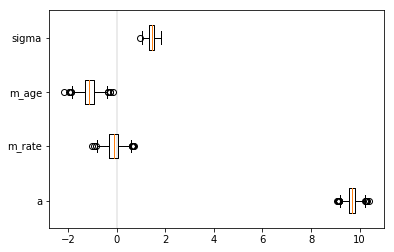

In [26]:
posterior_stats(solution_regression, ['a','m_rate','m_age','sigma'], plot = True)

What does this result tell us? That once age is known, there is little information that is brought by marriage rate for predicting divorces.

## Masking relationships

We are now going to investigate the issue of linear modeling when predictors behave similarly.

We are going to explore a dataset about primate milk composition (from Table 2 of Hinde and Milligan. 2011. Evolutionary Anthropology 20:9-23). The dataset is composed as follows:

- clade: Broad taxonomic group
- species: Species name
- kcal.per.g: Kilocalories per gram of milk
- perc.fat: Percent fat
- perc.protein: Percent protein
- perc.lactose: Percent lactose
- mass: Body mass of mother, in kilograms
- neocortex.perc: Percent of brain mass that is neocortex

In [27]:
data_milk = pd.read_csv('milk_clean.csv',sep=',')
print(data_milk.columns)

Index(['Unnamed: 0', 'clade', 'species', 'kcal.per.g', 'perc.fat',
       'perc.protein', 'perc.lactose', 'mass', 'neocortex.perc'],
      dtype='object')


We are interested in the relationship between the energy associated to the milk of a species, and the relative volume of the neocortex.  

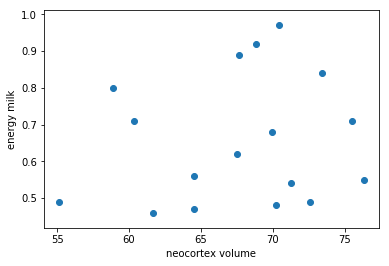

In [29]:
plt.scatter(data_milk['neocortex.perc'], data_milk['kcal.per.g'])
plt.xlabel('neocortex volume')
plt.ylabel('energy milk')
plt.show()


/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 3.00231020344466
 hess_inv: array([[ 2.04066290e-01, -3.02804772e-03, -1.94929010e-05],
       [-3.02804772e-03,  4.52240028e-05,  4.62552933e-07],
       [-1.94929010e-05,  4.62552933e-07,  7.56427022e-04]])
      jac: array([0.00023967, 0.0219062 , 0.001872  ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 628
      nit: 35
     njev: 122
   status: 2
  success: False
        x: array([0.35260095, 0.00451405, 0.16569909])
           mean        SD      7.5%     92.5%
a      0.347137  0.446597 -0.273757  0.996176
b      0.004601  0.006671 -0.005189  0.013854
sigma  0.164684  0.028427  0.123980  0.204586


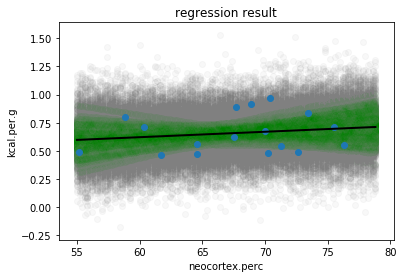

In [30]:
expr = 'kcal.per.g ~ neocortex.perc'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 0
prior_a_sigma = 10
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 20
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

solution_regression = laplace_solution_regression(expr, data_milk, likelihood, priors)
posterior_stats(solution_regression, ['a','b','sigma'])
posterior_plot_univariate_regression(solution_regression, np.arange(55,79,0.2), data_milk, names = ['neocortex.perc','kcal.per.g'])

There is some sort of association, although not very strong. Here is instead the relationship between mil energy and (log) mass of the species: 

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 2.0722197456490488
 hess_inv: array([[ 2.25178584e-03, -5.91629720e-04,  3.24796929e-05],
       [-5.91629720e-04,  3.95913177e-04, -3.04587870e-05],
       [ 3.24796929e-05, -3.04587870e-05,  6.63014350e-04]])
      jac: array([-5.96046448e-07, -4.11272049e-06, -3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 260
      nit: 35
     njev: 51
   status: 0
  success: True
        x: array([ 0.70513979, -0.0316831 ,  0.15685834])
           mean        SD      7.5%     92.5%
a      0.705333  0.049239  0.636209  0.780118
b     -0.031560  0.019933 -0.060891 -0.003362
sigma  0.156578  0.025376  0.119902  0.193650


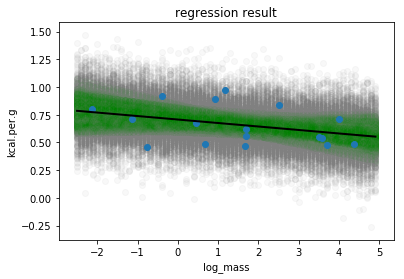

In [32]:
data_milk['log_mass'] = np.log(data_milk['mass'])

expr = 'kcal.per.g ~ log_mass'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 0
prior_a_sigma = 10
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 20
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

solution_regression = laplace_solution_regression(expr, data_milk, likelihood, priors)
posterior_stats(solution_regression, ['a','b','sigma'])
posterior_plot_univariate_regression(solution_regression, np.arange(-2.5,5,0.1), data_milk, names = ['log_mass','kcal.per.g'])

This association seems to be a bit stronger, although still not very strong. What happens when we consider the variables jontly? 

In [34]:
expr = 'kcal.per.g ~ log_mass + neocortex.perc'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 10
prior_a_sigma = 100
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_log_m_mean = 0
prior_log_m_sigma = 1
prior_log_m = ['gaussian', [prior_log_m_mean, prior_log_m_sigma]]

prior_neoc_mean = 0
prior_neoc_sigma = 1
prior_neoc = ['gaussian', [prior_neoc_mean, prior_neoc_sigma]]

sigma_inf = 0
sigma_sup = 10
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_log_m, prior_neoc, prior_sigma]

solution_regression_multiple = laplace_solution_regression(expr, data_milk, likelihood, priors)
posterior_stats(solution_regression_multiple, ['a','log_m','neocortex.perc','sigma'])


/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: -3.001960152211815
 hess_inv: array([[ 2.05998222e-01,  7.14145328e-03, -3.18765830e-03,
         2.63215790e-04],
       [ 7.14145328e-03,  4.62313241e-04, -1.16038697e-04,
         3.44812045e-05],
       [-3.18765830e-03, -1.16038697e-04,  4.96038105e-05,
        -4.49954771e-06],
       [ 2.63215790e-04,  3.44812045e-05, -4.49954771e-06,
         3.59743672e-04]])
      jac: array([0.00028455, 0.00177777, 0.02269101, 0.00026608])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 836
      nit: 52
     njev: 137
   status: 2
  success: False
        x: array([-1.08404564, -0.09633629,  0.02791132,  0.11478609])
                    mean        SD      7.5%     92.5%
a              -1.055721  0.452113 -1.699781 -0.404437
log_m          -0.095351  0.021188 -0.126168 -0.065502
neocortex.perc  0.027461  0.007015  0.017301  0.037560
sigma           0.113785  0.020184  0.084011  0.143684


Both associations now seem much stronger. Let's explore them with what is called *counterfactual* prediction.

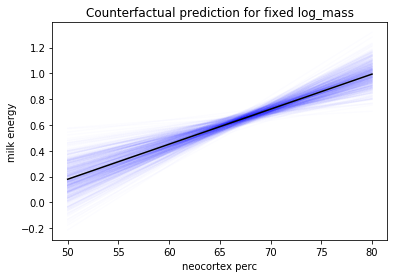

In [35]:
post_sample = post_sample_Laplace(solution_regression_multiple, 500)

neoc_range = np.linspace(50,80)
counterfactual_predict = []
for i in range(500):
    counterfactual_predict.append(post_sample [i,0] + post_sample[i,1] * np.mean(data_milk.log_mass) + post_sample[i,2] * neoc_range)
    plt.plot(neoc_range, counterfactual_predict[i], color = 'blue', alpha = 0.01)

plt.plot(neoc_range, np.mean(counterfactual_predict,0), color = 'black', alpha = 1)    
plt.xlabel('neocortex perc')
plt.ylabel('milk energy')
plt.title('Counterfactual prediction for fixed log_mass')
plt.show()

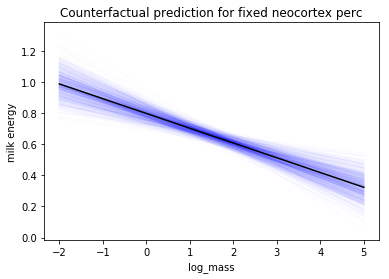

In [36]:
log_mass_range = np.linspace(-2,5)
counterfactual_predict = []
for i in range(500):
    counterfactual_predict.append(post_sample [i,0] + post_sample[i,1] * log_mass_range + post_sample[i,2] * np.mean(data_milk['neocortex.perc']))
    plt.plot(log_mass_range, counterfactual_predict[i], color = 'blue', alpha = 0.01)

plt.plot(log_mass_range, np.mean(counterfactual_predict,0), color = 'black', alpha = 1)  

plt.xlabel('log_mass')
plt.ylabel('milk energy')
plt.title('Counterfactual prediction for fixed neocortex perc')
plt.show()

How can this be possible? To understand this point we need to think of the meaning of a question asked by a linear model. For a given value of neocortex volume, the relationship between mass and milk enrgy is negative. In the same way, for a given value of mass, the relationship between neocortex volume and milk enrgy is positive. 

How this can be possible?


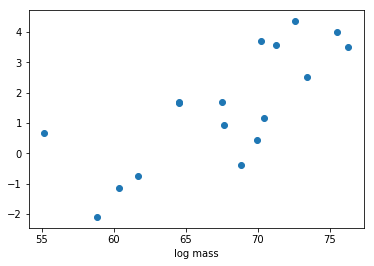

In [40]:
plt.scatter(data_milk['neocortex.perc'], data_milk['log_mass'])
plt.xlabel('neocortex perc')
plt.xlabel('log mass')
plt.show()

## Collinearity

In [41]:
N = 100
height = norm.rvs(50,10,N)

leg_proportion = uniform.rvs(0.43, 0.46, N)

In [42]:

left_leg = norm.rvs(leg_proportion * height, 2)
right_leg = norm.rvs(leg_proportion* height, 2)

left_leg = np.array(left_leg)
right_leg = np.array(right_leg)

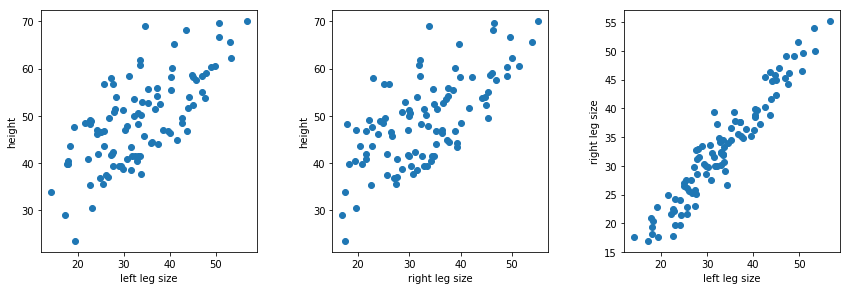

In [43]:
plt.subplot(1, 3, 1)
plt.scatter(left_leg, height)
plt.xlabel('left leg size')
plt.ylabel('height')

plt.subplot(1, 3, 2)
plt.scatter(right_leg, height)
plt.xlabel('right leg size')
plt.ylabel('height')

plt.subplot(1, 3, 3)
plt.scatter(left_leg, right_leg)
plt.xlabel('left leg size')
plt.ylabel('right leg size')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=1.95, hspace=0.25,
                    wspace=0.35)

In [44]:
data_height = pd.DataFrame({'height': height, 'left_leg': left_leg, 'right_leg': right_leg})

In [45]:
expr = 'height ~ left_leg + right_leg'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 50
prior_a_sigma = 100
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_left_mean = 0
prior_left_sigma = 10
prior_left = ['gaussian', [prior_left_mean, prior_left_sigma]]

prior_right_mean = 0
prior_right_sigma = 10
prior_right = ['gaussian', [prior_right_mean, prior_right_sigma]]

sigma_inf = 0
sigma_sup = 10
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_left, prior_right, prior_sigma]

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 346.5820741962788
 hess_inv: array([[ 0.03557497, -0.03401732,  0.03357518,  0.00166479],
       [-0.03401732,  0.06165277, -0.06190111, -0.00259049],
       [ 0.03357518, -0.06190111,  0.06245618,  0.00247594],
       [ 0.00166479, -0.00259049,  0.00247594,  0.00206053]])
      jac: array([ 0.00000000e+00,  1.52587891e-05,  2.28881836e-05, -1.14440918e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 303
      nit: 36
     njev: 50
   status: 2
  success: False
        x: array([25.9166804 ,  0.57635043,  0.1176534 ,  6.71186874])
            mean        SD       7.5%      92.5%
a      25.919653  0.188570  25.652830  26.194554
left    0.566558  0.253054   0.189991   0.942189
right   0.127710  0.254939  -0.247839   0.505950
sigma   6.712806  0.045189   6.647238   6.775727


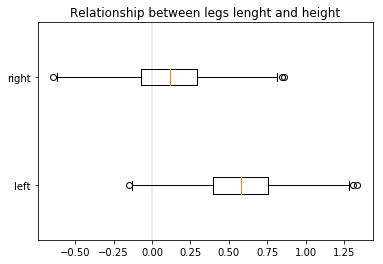

In [46]:
solution_regression_height = laplace_solution_regression(expr, data_height, likelihood, priors)
posterior_stats(solution_regression_height, ['a','left','right','sigma'])

posterior_samples = post_sample_Laplace(solution_regression_height, 1000)

boxes = []
boxes.append(posterior_samples[:,1])
boxes.append(posterior_samples[:,2])

plt.boxplot(boxes,vert=0)
plt.yticks([1,2], ['left', 'right'])
plt.axvline(x=0, color = 'black', alpha = 0.1)
plt.title('Relationship between legs lenght and height')
plt.show()

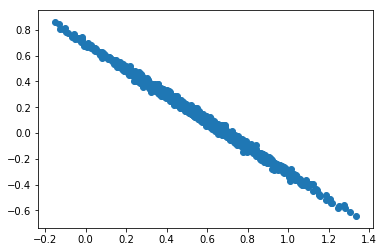

In [47]:
plt.scatter(posterior_samples[:,1] , posterior_samples[:,2])

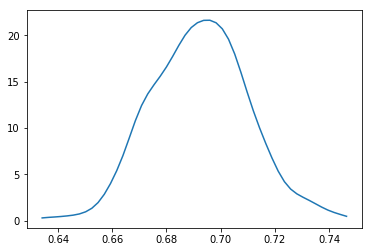

In [48]:
post_sum = posterior_samples[:,1] + posterior_samples[:,2]

kernel = gaussian_kde(post_sum)
plt.plot(np.linspace(np.min(post_sum),np.max(post_sum)),kernel(np.linspace(np.min(post_sum),np.max(post_sum))))



In [49]:
print('The mean sum of the parameters is: ', np.mean(post_sum))
print('85% Confidence interval for the sum of the parameters: \n', np.quantile(post_sum, q = [0.075, 0.925], axis = 0))

The mean sum of the parameters is:  0.6923735303184696
85% Confidence interval for the sum of the parameters: 
 [0.66796321 0.71709433]


In [50]:
expr = 'height ~ right_leg '

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 50
prior_a_sigma = 100
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_left_mean = 0
prior_left_sigma = 10
prior_left = ['gaussian', [prior_left_mean, prior_left_sigma]]

sigma_inf = 1
sigma_sup = 5
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_left, prior_sigma]

solution_regression_height = laplace_solution_regression(expr, data_height, likelihood, priors)
posterior_stats(solution_regression_height, ['a','right','sigma'])

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 347.90116680942185
 hess_inv: array([[ 4.31388332e-01, -1.22406058e-02,  5.09622281e-02],
       [-1.22406058e-02,  3.71011356e-04, -7.29421813e-04],
       [ 5.09622281e-02, -7.29421813e-04,  1.06964824e-01]])
      jac: array([ -1.08847809, -36.01195908,  -5.89715195])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 202
      nit: 18
     njev: 38
   status: 2
  success: False
        x: array([26.03312019,  0.68412044,  5.93675213])
            mean        SD       7.5%      92.5%
a      26.039014  0.646988  25.113446  26.969315
right   0.683653  0.019022   0.655469   0.710318
sigma   5.937673  0.332934   5.453169   6.408803


In [52]:
expr = 'height ~ left_leg '

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 50
prior_a_sigma = 100
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_left_mean = 0
prior_left_sigma = 10
prior_left = ['gaussian', [prior_left_mean, prior_left_sigma]]

sigma_inf = 1
sigma_sup = 5
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_left, prior_sigma]

solution_regression_height = laplace_solution_regression(expr, data_height, likelihood, priors)
posterior_stats(solution_regression_height, ['a','left','sigma'])

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 373.6811232061326
 hess_inv: array([[ 1.93763862e-01, -5.34543876e-03,  9.53784816e-03],
       [-5.34543876e-03,  1.61683120e-04,  2.44254408e-04],
       [ 9.53784816e-03,  2.44254408e-04,  5.97178242e-02]])
      jac: array([ -12.73138428, -438.56754684,  -14.18588638])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 232
      nit: 22
     njev: 43
   status: 2
  success: False
        x: array([23.5337614 ,  0.62751877,  5.98576924])
            mean        SD       7.5%      92.5%
a      23.543204  0.423414  22.904332  24.154056
left    0.627030  0.012148   0.609510   0.644738
sigma   5.973343  0.237864   5.646636   6.326488


**Exercise.** By exploring our first dataset, it seems that the number of Waffle houses in a state is related to the divorce rate. How can you explin this result? 

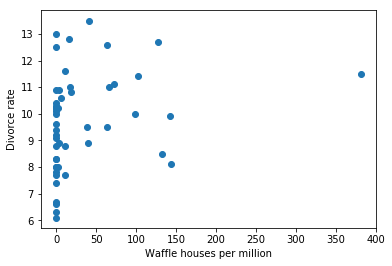

In [57]:
plt.scatter(data.WaffleHouses,data.Divorce)
plt.xlabel('Waffle houses per million')
plt.ylabel('Divorce rate')
plt.show()

In [58]:
expr = 'Divorce ~   WaffleHouses'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 178
prior_a_sigma = 100
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 50
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 112.8102252565369
 hess_inv: array([[ 5.31815414e-02, -3.27861906e-04, -1.13750184e-02],
       [-3.27861906e-04,  1.34634788e-05,  6.64223351e-05],
       [-1.13750184e-02,  6.64223351e-05,  2.58512862e-02]])
      jac: array([9.53674316e-07, 1.90734863e-06, 9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 208
      nit: 30
     njev: 41
   status: 0
  success: True
        x: array([9.46150847e+00, 7.03512238e-03, 1.74317412e+00])
           mean        SD      7.5%     92.5%
a      9.464173  0.227704  9.145865  9.796946
b      0.007004  0.003802  0.001523  0.012669
sigma  1.750160  0.158254  1.531221  1.979349


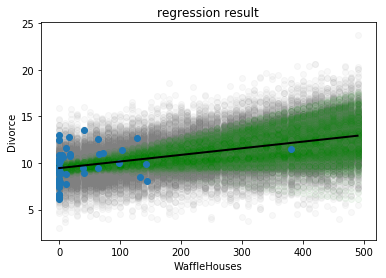

In [59]:
solution_regression = laplace_solution_regression(expr, data, likelihood, priors)
posterior_stats(solution_regression, ['a','b','sigma'])
posterior_plot_univariate_regression(solution_regression, np.arange(0,500,10), data, names = ['WaffleHouses','Divorce'])

**Exercise.** Analyse the relationship of milk energy with respect to percentage of fat and percentage of lactose.

   ## Model comparison

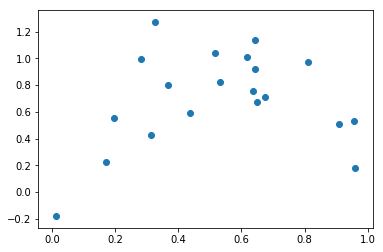

In [225]:
N = 20
noise = 0.3
x = np.random.uniform(0,1,N)
y = np.sin(x*3) + noise * np.random.randn(N)

data_synth = pd.DataFrame({'x' : x, 'y' : y})

plt.scatter(x,y)

In [226]:
degree = 10
likelihood = 'gaussian'

models = []

for i in range(degree):
    
    data_poly = pd.DataFrame({'y' : y})

    priors = []

    prior_a_mean = 0
    prior_a_sigma = 5
    prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

    priors.append(prior_a)
    
    if i > 0:
        expr = 'y ~ '
        for k in range(1,i+1):
            if k>1:
                expr = expr + '+'
            prior_param_mean = 0
            prior_param_sigma = 5
            prior_param = ['gaussian', [prior_param_mean, prior_param_sigma]]
            priors.append(prior_param)
            data_poly['x'+str(k)] = x**k
            expr = expr + 'x' + str(k)

    sigma_inf = 0.1
    sigma_sup = 5
    prior_sigma_unif = [sigma_inf, sigma_sup]
    prior_sigma = ['uniform', prior_sigma_unif]

    priors.append(prior_sigma)
    
    if i > 0:
        models.append(laplace_solution_regression(expr, data_poly, likelihood, priors))
    else:
        models.append(laplace_solution([1,1],[],data_poly['y'], likelihood, priors))    

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 11.359005665800746
 hess_inv: array([[6.03499559e-03, 3.61993731e-06],
       [3.61993731e-06, 3.01395227e-03]])
      jac: array([0.00000000e+00, 3.57627869e-07])
  message: 'Optimization terminated successfully.'
     nfev: 77
      nit: 7
     njev: 18
   status: 0
  success: True
        x: array([0.69733701, 0.34702264])


/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 13.508078068873905
 hess_inv: array([[ 3.00189204e-02, -4.54005140e-02, -7.68242106e-06],
       [-4.54005140e-02,  8.50727475e-02,  6.55789337e-05],
       [-7.68242106e-06,  6.55789337e-05,  2.85293159e-03]])
      jac: array([ 3.57627869e-07,  1.19209290e-07, -1.31130219e-06])
  message: 'Optimization terminated successfully.'
     nfev: 203
      nit: 18
     njev: 39
   status: 0
  success: True
        x: array([0.56071018, 0.25648854, 0.34053942])


/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 7.30148703628047
 hess_inv: array([[ 2.63688398e-02, -9.53266711e-02,  7.65998590e-02,
         1.91612151e-04],
       [-9.53266711e-02,  4.37549276e-01, -3.94048372e-01,
        -1.02937681e-03],
       [ 7.65998590e-02, -3.94048372e-01,  3.80390709e-01,
         8.80645658e-04],
       [ 1.91612151e-04, -1.02937681e-03,  8.80645658e-04,
         1.03914073e-03]])
      jac: array([-2.14576721e-06, -1.72853470e-06, -7.74860382e-07, -7.74860382e-06])
  message: 'Optimization terminated successfully.'
     nfev: 273
      nit: 36
     njev: 45
   status: 0
  success: True
        x: array([-0.1425516 ,  3.85125891, -3.44568822,  0.21431296])


/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 9.820793911690114
 hess_inv: array([[ 3.79585847e-02, -2.12576051e-01,  3.49238813e-01,
        -1.75404638e-01,  7.26939584e-04],
       [-2.12576051e-01,  1.78952628e+00, -3.64434374e+00,
         2.11011331e+00, -8.13472438e-03],
       [ 3.49238813e-01, -3.64434374e+00,  8.30757651e+00,
        -5.18323118e+00,  1.79716472e-02],
       [-1.75404638e-01,  2.11011331e+00, -5.18323118e+00,
         3.40508488e+00, -1.08595528e-02],
       [ 7.26939584e-04, -8.13472438e-03,  1.79716472e-02,
        -1.08595528e-02,  1.24136305e-03]])
      jac: array([ 5.24520874e-06,  2.38418579e-07, -4.76837158e-07, -8.34465027e-07,
        2.38418579e-07])
  message: 'Optimization terminated successfully.'
     nfev: 281
      nit: 28
     njev: 40
   status: 0
  success: True
        x: array([-0.1302829 ,  3.7051635 , -3.08159302, -0.24194501,  0.21495082])


/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 12.32554613619325
 hess_inv: array([[ 4.44793561e-02, -2.38944350e-01,  3.11163895e-01,
         1.05586211e-02, -1.33409105e-01,  6.78915738e-04],
       [-2.38944350e-01,  1.85084351e+00, -3.38887608e+00,
         1.26347608e+00,  5.91279218e-01, -6.37708364e-03],
       [ 3.11163895e-01, -3.38887608e+00,  9.03992960e+00,
        -8.20822276e+00,  2.12142694e+00,  1.26997758e-02],
       [ 1.05586211e-02,  1.26347608e+00, -8.20822276e+00,
         1.49102689e+01, -8.10261359e+00, -5.84843697e-03],
       [-1.33409105e-01,  5.91279218e-01,  2.12142694e+00,
        -8.10261359e+00,  5.73580734e+00, -8.02640201e-04],
       [ 6.78915738e-04, -6.37708364e-03,  1.26997758e-02,
        -5.84843697e-03, -8.02640201e-04,  1.12215664e-03]])
      jac: array([ 3.81469727e-06,  3.81469727e-06,  4.05311584e-06,  3.33786011e-06,
        2.98023224e-06, -5.72204590e-06])
  message: 'Optimization terminated successfully.'
     nfev: 391
      nit: 29
     njev: 48
   status: 0
  success:

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 14.853732893491227
 hess_inv: array([[ 4.19517189e-02, -2.14406625e-01,  2.42573507e-01,
         4.09799864e-02, -4.74688754e-02, -6.94479119e-02,
         5.78533874e-04],
       [-2.14406625e-01,  1.75018903e+00, -3.41265959e+00,
         1.40233140e+00,  9.94967934e-01, -4.87322675e-01,
        -5.54380017e-03],
       [ 2.42573507e-01, -3.41265959e+00,  1.05868909e+01,
        -9.26931319e+00, -2.04537819e+00,  3.93413645e+00,
         1.52058900e-02],
       [ 4.09799864e-02,  1.40233140e+00, -9.26931319e+00,
         1.51980274e+01, -5.16003151e+00, -2.38352794e+00,
        -9.86540330e-03],
       [-4.74688754e-02,  9.94967934e-01, -2.04537819e+00,
        -5.16003151e+00,  1.53259033e+01, -9.18726638e+00,
        -9.89828521e-03],
       [-6.94479119e-02, -4.87322675e-01,  3.93413645e+00,
        -2.38352794e+00, -9.18726638e+00,  8.46305486e+00,
         9.62842359e-03],
       [ 5.78533874e-04, -5.54380017e-03,  1.52058900e-02,
        -9.86540330e-03, -9.89828521

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 19.817889808178684
 hess_inv: array([[ 3.87213664e-02, -2.04233414e-01,  2.53197865e-01,
         3.35624300e-02, -9.48576808e-02, -3.74178603e-02,
        -3.82750963e-02,  4.44300915e-02,  6.05272966e-04],
       [-2.04233414e-01,  1.70127100e+00, -3.30414518e+00,
         8.33353556e-01,  1.45678069e+00,  3.47120123e-01,
        -1.92577733e-01, -6.47712540e-01, -7.57000953e-03],
       [ 2.53197865e-01, -3.30414518e+00,  9.48294255e+00,
        -6.12919922e+00, -3.73172660e+00,  3.25673168e-01,
         2.73880792e+00,  5.08720294e-01,  1.70792045e-02],
       [ 3.35624300e-02,  8.33353556e-01, -6.12919922e+00,
         9.91088406e+00, -1.19004636e+00, -2.24759288e+00,
        -5.95231925e+00,  4.70012066e+00, -9.40425221e-04],
       [-9.48576808e-02,  1.45678069e+00, -3.73172660e+00,
        -1.19004636e+00,  8.65115522e+00, -5.25317700e+00,
         4.19544423e+00, -4.26082436e+00, -1.38462379e-02],
       [-3.74178603e-02,  3.47120123e-01,  3.25673168e-01,
        -2

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 22.246430650344752
 hess_inv: array([[ 4.19618542e-02, -2.16186533e-01,  2.58354455e-01,
         3.84841801e-02, -7.91778791e-02, -7.18111654e-02,
        -3.65641625e-02,  2.17397567e-02,  4.41020588e-02,
         6.78805047e-04],
       [-2.16186533e-01,  1.79055895e+00, -3.50032902e+00,
         8.38899403e-01,  1.48895187e+00,  6.43878664e-01,
        -6.57789510e-02, -5.30818736e-01, -5.13156514e-01,
        -6.90964087e-03],
       [ 2.58354455e-01, -3.50032902e+00,  1.02241620e+01,
        -6.55544339e+00, -4.01281582e+00,  1.00808863e-01,
         2.25014837e+00,  1.07408430e+00,  3.87998479e-01,
         1.62954722e-02],
       [ 3.84841801e-02,  8.38899403e-01, -6.55544339e+00,
         1.12988159e+01, -1.55775683e+00, -4.12188826e+00,
        -4.67085154e+00,  3.59151032e+00,  1.16344632e+00,
        -2.20431131e-04],
       [-7.91778791e-02,  1.48895187e+00, -4.01281582e+00,
        -1.55775683e+00,  8.33485498e+00,  6.01085483e-01,
        -8.92859697e-01, -7.9

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 24.674565138440933
 hess_inv: array([[ 3.88544486e-02, -2.05933008e-01,  2.34629455e-01,
         6.18669272e-02, -3.22282448e-02, -8.23178736e-02,
        -7.13605553e-02, -4.02731319e-02,  4.56586156e-03,
         9.31671840e-02,  8.58552907e-04],
       [-2.05933008e-01,  1.63307322e+00, -2.88723387e+00,
         5.96731132e-01,  4.56981435e-01,  5.72985357e-01,
         4.47412116e-01,  4.39238748e-01,  1.90091507e-01,
        -1.31338687e+00, -8.33843412e-03],
       [ 2.34629455e-01, -2.88723387e+00,  8.13904726e+00,
        -6.31305424e+00, -7.10635084e-01,  1.13949174e+00,
         4.15925417e-01, -1.46993258e+00, -1.71535726e+00,
         3.40117343e+00,  1.47407176e-02],
       [ 6.18669272e-02,  5.96731132e-01, -6.31305424e+00,
         1.20388409e+01, -1.50883859e+00, -6.60487110e+00,
        -3.04257966e+00,  2.15202296e+00,  3.70009059e+00,
        -1.01985877e+00,  3.65323610e-03],
       [-3.22282448e-02,  4.56981435e-01, -7.10635084e-01,
        -1.50883859e

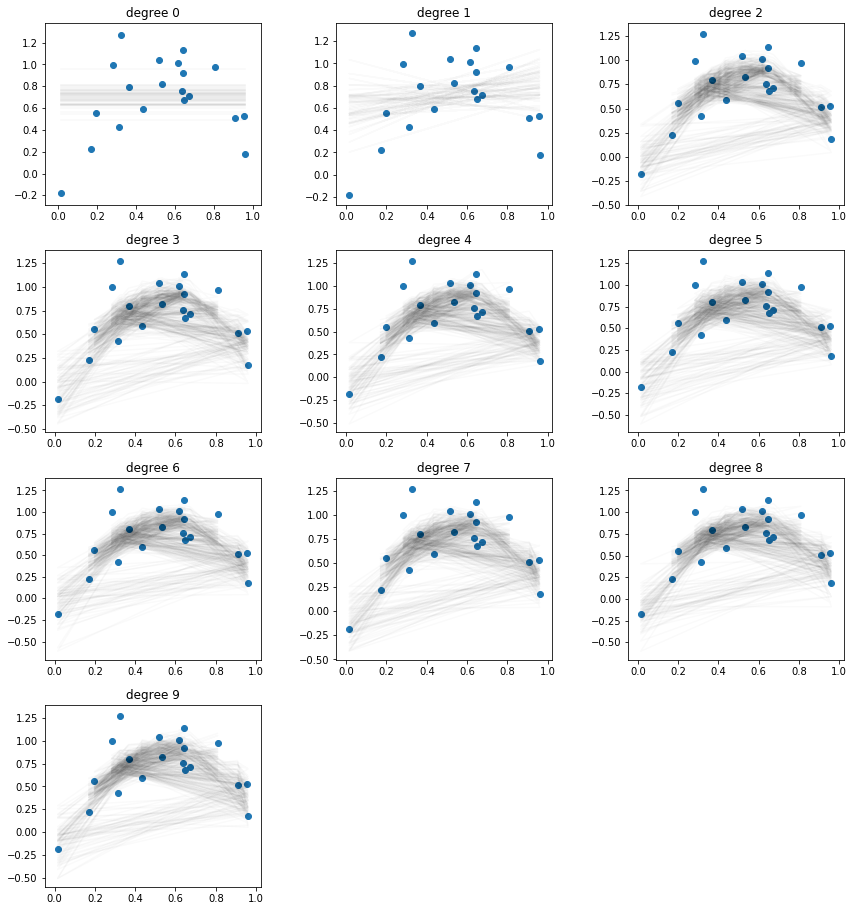

In [229]:
N_samp = 50

for i in range(degree):
    plt.subplot(int(float(degree)/3)+1,3,i+1)

    samples = post_sample_Laplace(models[i], N_samp)
    for l in range(N_samp):
        if i>0:
            pred = np.sum([x**k * samples[l,k] for k in range(i+1)],0)
        else:
            pred = x**0 * samples[l,0]
        plt.plot(x,pred, color = 'black', alpha = 0.02)
    
    plt.scatter(x,y)
    plt.title('degree ' + str(i))    
    plt.subplots_adjust(top=3, bottom=0.001, left=0.10, right=1.95, hspace=0.25,wspace=0.35)

-929.5314315173183 0.8792458850497527
-927.015837786631 2.29346015574058
-921.1199935701959 5.42098480653911
-919.6482268973375 3.8063039263306546
-920.3689575874373 3.4514505710603554
-921.8586173872266 11.324618940458155
-921.4726826838702 6.777695584660719
-920.2544024412156 5.226991192162903
-919.9901882393741 5.437204833426024
-920.347631715161 4.786135642085425


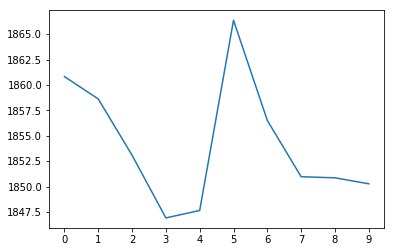

In [230]:
D = []

for i in range(degree):
    lppd = 0
    p_waic = 0
    samples = post_sample_Laplace(models[i], N_samp)
    for k,target in enumerate(y):
        log_p = []
        for l in range(len(samples)):
            if i>0:
                pred = np.sum([x**k * samples[l,k] for k in range(i+1)],0)
                log_p.append(norm.logpdf(target,pred[k],samples[k][-1]))
            else:
                pred = x**0 * samples[l,0]
                log_p.append(norm.logpdf(target,pred[k],samples[k][-1]))
    
        lppd += scipy.special.logsumexp(log_p) - len(log_p)
        p_waic += np.var(log_p)
    
    print(lppd, p_waic)
    
    D.append(-2*( lppd - p_waic))   

plt.plot(range(degree),D)
plt.xticks(range(degree))
plt.show()